# NACA library data wrangling

This script converts .xml data from the NACA library University of North Texas API to a custom JSON structure for visualization. Basic plot experiments are also included.

In [4]:
from datetime import datetime
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import pprint
pp = pprint.PrettyPrinter(indent=0)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [5]:
# function to clean up records for new final data set

def mylistHelper(record,recordtype):
    title = [];
    title2 = [];
    flag = 1;
    more = [];
    
    # Handling or dict variables
    if (type(record) is dict):
        title = list(record.values())
        if (recordtype == 'creator') or (recordtype == 'contr') or (recordtype == 'id_repno'):
            more.append(title[1])
        return title[1], more
    
    
    # https://..., url: http:..., rep-no (2), casi:
    elif (recordtype == 'id_url'):
        for k in record:
            if k['__text'].startswith('url:'):
                title = k['__text'][5:]
        return title
    elif (recordtype == 'id_https'):
        for k in record:
            if k['__text'].startswith('https://'):
                title = k['__text']
        return title
    elif (recordtype == 'id_casi'):
        for k in record:
            if k['__text'].startswith('casi:'):
                title = k['__text'][6:]
        return title
    elif (recordtype == 'id_repno'):
        more = [];
        for k in record:
            if k['__text'].startswith('rep-no:') and flag:
                title = k['__text'][8:]
                more.append(title)
                flag = 0
            elif k['__text'].startswith('rep-no:'):
                title2 = k['__text'][8:]
                more.append(title2)
        return title, more
    
    elif (recordtype == 'keywords'):
        for k in record:
            title.append(k['__text'])
        return title
    
    
    elif type(record) is list:
        title = record[0]['__text']
        for k in record:
            kk = k['__text']
            if (recordtype == 'title') and ('NACA' in kk):
                if ("note" in kk.lower()) or ("memorandum" in kk.lower()) or ("reports" in kk.lower()) or ("circulars" in kk.lower()) or ("bulletin" in kk.lower()) and (", special report" not in kk.lower()):
                    more.append(k['__text'])
            elif (recordtype == 'contr'):
                more.append(k['__text'])
            elif (recordtype == 'creator'):
                more.append(k['__text'])


        return title, more
    
def mydatehelper(mixdate):
    tempdate = str(mixdate)
    if tempdate == '1989?': 
        tempdate='1939'
    tempdate = str(tempdate).strip('~?}{')
    month =''
#     print(tempdate)
#     print('this is raw date: '+tempdate+' with length'+str(len(tempdate)))
    
    if len(tempdate) == 4:
        year = str(mixdate[0:4])
        month = '06'
    elif len(tempdate.strip(' -~?')) > 5:
        year = str(tempdate[0:4])
        month = str(tempdate[5:7])
#         print('reconstructed: '+year+' '+month)
#     print(year+'-'+month)
    return year+'-'+month
    

In [6]:
# Load the separate data files into one and consolidate

fullset = []
temprec = {}
# data = []
dummy = {}


# loop through the 14 text files that has data in json format
for i in range(1,15):
#     print('File: ',i)
    with open('test_data_'+str(i)+'.txt',encoding="utf-8") as json_file:
        data = json.load(json_file)
#         print('File:',i,'Length',len(data['record']))
        for rec in data['record']:
#             fullset.append(rec)
#             print('--------------------')
#             print('file',i,rec['header']['identifier'])
            
            temprec = {}
#             print(mylistHelper(rec['metadata']['dc']['title']))
            temprec['title'],temprec['doctype'] = mylistHelper(rec['metadata']['dc']['title'],'title')
#             print(temprec['title'])
#             print(temprec['doctype'])


            if 'contributor' in rec['metadata']['dc']:
                temprec['contributor'],dummy = mylistHelper(rec['metadata']['dc']['contributor'],'contr')
#                 print(temprec['contributor'])
#                 print(dummy)

                
            if 'creator' in rec['metadata']['dc']:
                temprec['creator'],temprec['creat2'] = mylistHelper(rec['metadata']['dc']['creator'],'creator')
#                 print(temprec['creator'])
#                 print(temprec['creat2'])
                separator = ' and '
                temprec['creatorsall'] = separator.join(temprec['creat2'])
                
            temprec['date'] = mydatehelper(rec['metadata']['dc']['date']['__text'])
            temprec['year'] = int(temprec['date'][:4])
#             print(temprec['date'])
#             print(temprec['year'])
            
            temprec['abstr'] = rec['metadata']['dc']['description']['__text']
#             print(temprec['abstr'])
            
            temprec['pp'] = rec['metadata']['dc']['format'][0]['__text'].split(' ')[0]
            temprec['pp'] = temprec['pp'].split('-')[0].strip('\[\],vxip.X')
            if temprec['pp'] == '': temprec['pp']=1
            temprec['pp'] = int(temprec['pp'])
#             print(temprec['pp'])
            
            temprec['id_hd'] = rec['header']['identifier'][15:]
#             print(temprec['id_hd'])
            
            temprec['id_url'] = mylistHelper(rec['metadata']['dc']['identifier'],'id_url')
#             print(temprec['id_url'])
        
            temprec['id_https'] = mylistHelper(rec['metadata']['dc']['identifier'],'id_https')
#             print(temprec['id_https'])
            
            temprec['id_casi'] = mylistHelper(rec['metadata']['dc']['identifier'],'id_casi')
#             print(temprec['id_casi'])
            
            temprec['id_repno'],temprec['id_repno2'] = mylistHelper(rec['metadata']['dc']['identifier'],'id_repno')
#             print(temprec['id_repno'])
#             print(temprec['id_repno2'])
            separator = ' '
            temprec['id_repno_all'] = str(separator.join(temprec['id_repno2']))
        
            
            temprec['keywords'] = mylistHelper(rec['metadata']['dc']['subject'],'keywords')
#             print(temprec['keywords'])
            separator = ' '
            temprec['keywordsall'] = separator.join(temprec['keywords'])

            
            temprec['x'] = np.random.random()*0.3+np.random.random()*0.5 + (round((round(np.random.random()*100)/10) %10))
            temprec['y'] = temprec['year'] + np.random.random()
    
            fullset.append(temprec)
            
# print(fullset[1]['header']['identifier'])
# print(fullset[1]['metadata']['dc']['title'][0]['__text'])
# print(fullset[1]['metadata']['dc']['title'][1]['__text'])
# print(fullset[1]['metadata']['dc']['title'][2]['__text'])
# print(fullset[1]['metadata']['dc']['contributor']['__text'])
# print(fullset[1]['metadata']['dc']['creator']['__text'])
# print(fullset[1]['metadata']['dc']['date']['__text'])
# print(fullset[1]['metadata']['dc']['description']['__text'])
# print(fullset[1]['metadata']['dc']['format'][0]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][0]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][1]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][2]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][3]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][4]['__text'])
# print(fullset[1]['metadata']['dc']['identifier'][5]['__text'])
# print(fullset[1]['metadata']['dc']['subject'][0]['__text'])
# print(fullset[1]['metadata']['dc']['subject'][1]['__text'])
# print(fullset[1]['metadata']['dc']['subject'][2]['__text'])

# exceptions
# ['metadata']['dc']['title'][0]['__text'])
# ['metadata']['dc']['contributor']['__text']
# ['metadata']['dc']['creator']['__text']
# date: year, year-month, year-month-day
# pages; different formats
# order of ['metadata']['dc']['identifier'][1]['__text']   # https://..., url: http:..., rep-no (2), casi: 
# ['metadata']['dc']['subject'][0]['__text']   # keywords

df = pd.DataFrame(fullset)
# print(df.columns)
df2 = df[['title','creatorsall','year','pp','id_hd','id_casi','id_repno','y','x','keywordsall','id_repno_all']]
df2.to_csv (r'testplot.csv', index = False, header=True)
# print(df)

# print(df2.head)
print(len(fullset))
pp.pprint(fullset[1])
# pp.pprint(fullset[1]['keywordsall'])

with open('naca_data.json', 'w') as fp:
    json.dump(fullset, fp)

13801
{'abstr': 'Report presenting a flight investigation made of boundary-layer and '
         'profile-drag characteristics of smooth wing sections of a P-47D '
         'airplane. Measurements were made at three stations on the wing: '
         'boundary-layer measurements, pressure-distribution measurements, and '
         'wake surveys. The results indicated that a minimum profile-drag '
         'coefficient of 0.0062 for the smooth section at 63 percent semispan '
         'was obtained.',
'contributor': 'Langley Aeronautical Laboratory',
'creat2': ['Zalovcik, John A.'],
'creator': 'Zalovcik, John A.',
'creatorsall': 'Zalovcik, John A.',
'date': '1945-10',
'doctype': ['NACA Advanced Confidential Reports', 'NACA Wartime Reports'],
'id_casi': '19780078667',
'id_hd': 'metadc53374',
'id_https': 'https://digital.library.unt.edu/ark:/67531/metadc53374/',
'id_repno': 'NASA-TM-79861',
'id_repno2': ['NASA-TM-79861', 'NACA-ACR-L5H11A'],
'id_repno_all': 'NASA-TM-79861 NACA-ACR-L5H11A',
'id

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


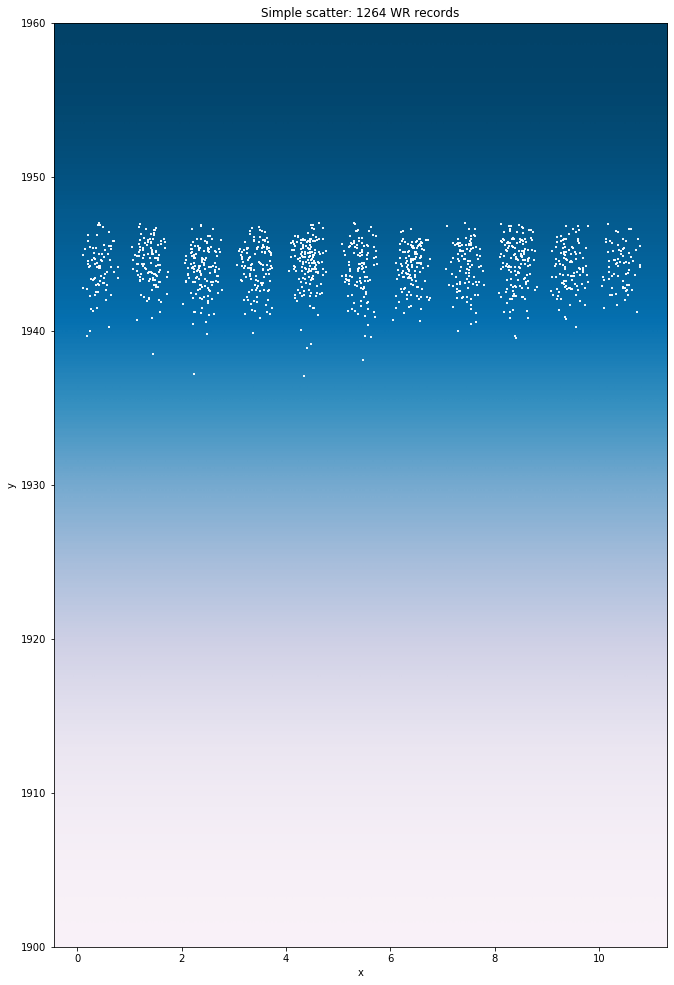

3        1944.694697
353      1942.734192
540      1944.333961
4931     1941.262303
4932     1944.528536
            ...     
13768    1945.755220
13769    1943.882535
13771    1944.150286
13772    1944.702371
13773    1944.657010
Name: y, Length: 1264, dtype: float64
3        NASA-TM-79829 NACA-CB-L4G17 NACA-WR-L-141
353              NACA-ACR NACA-SR-244 NACA-WR-A-40
540                  NACA-ARR-L4I11B NACA-WR-L-773
4931                        NACA-WR-L-365 NACA-ARR
4932                         NACA-WR-L-643 NACA-MR
                           ...                    
13768                NACA-ACR-L5F30a NACA-WR-L-729
13769                                NACA-WR-L-488
13771                                NACA-WR-L-112
13772                 NACA-WR-L-528 NACA-ACR-L4D26
13773                  NACA-WR-L-313 NACA-ARR-4A07
Name: id_repno_all, Length: 1264, dtype: object


In [7]:
# y = testplot['year']
# yy = y + np.random.random(len(y))*10
# print(len(y))
# # x = testplot['pp']*0+random()
# x = np.random.random(len(y))


# ['title','creator','year','pp','id_hd','id_casi','id_repno','y','x']
types = ['TR','TM','RM','TN','ACR','MR','ARR','CB','WR','RB']
rectype = 'id_repno_all'
keyword =  types[8]


# keyword = 'flutter'
# rectype = 'keywordsall'
subset_testplot = df2[df2[rectype].str.contains(keyword, regex=False)]


# size = [100,500,100,500]
plt.scatter(subset_testplot['x'],subset_testplot['y'],marker=',',s=1,c='#ffffffff')
# plt.scatter(df2['x'],df2['y'],marker=',',s=1,c='#ffffffff')


plt.title('Simple scatter: '+str(len(subset_testplot['x']))+' '+keyword+' records')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(1900, 1960)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 17)
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
# ax.set_facecolor('xkcd:salmon')
# ax.set_facecolor((1.0, 0.47, 0.42))
 
print(plt.cm.Blues)    
    
plotlim = plt.xlim() + plt.ylim()  
ax.imshow([[1,1],[0,0]], aspect='auto',cmap=plt.cm.PuBu, interpolation='bicubic', extent=plotlim)  

plt.draw() 

fig.savefig('test2png.png', dpi=100)

# plt.savefig('ScatterPlot_01.png')
plt.show()
print(subset_testplot['y'])
print(subset_testplot[rectype])

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


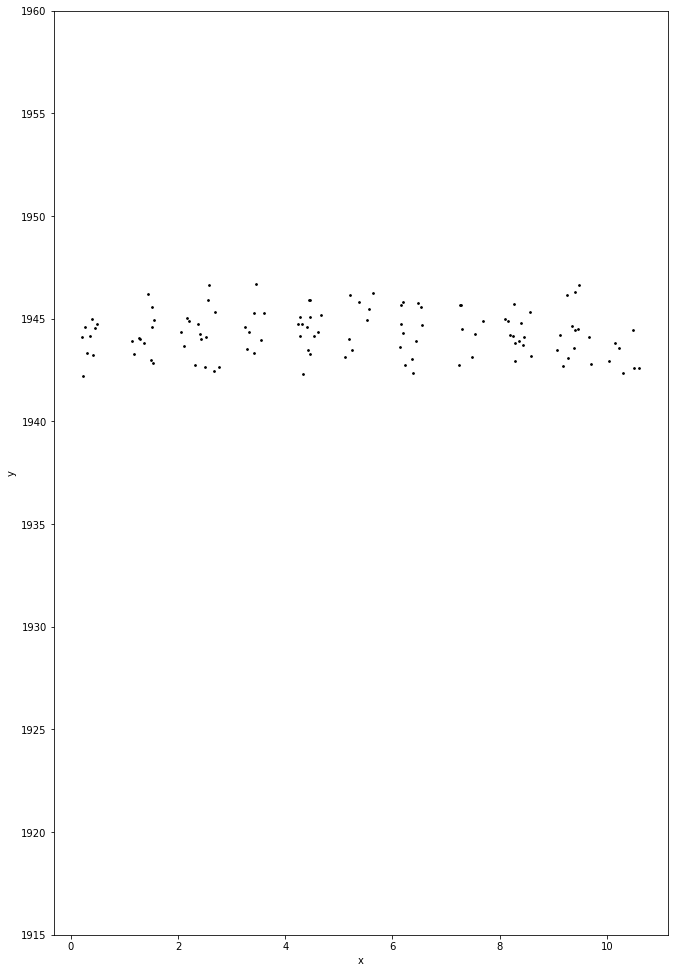

<bound method Series.max of 4956     1942.615540
5082     1942.866375
5180     1942.654324
5224     1942.447282
5231     1942.995280
            ...     
13687    1945.298938
13694    1943.108603
13737    1943.029381
13748    1945.915886
13756    1945.648919
Name: y, Length: 117, dtype: float64>
4956                          NACA-WR-W-77 NACA-RB
5082                          NACA-WR-W-79 NACA-RB
5180                         NACA-WR-L-555 NACA-RB
5224                         NACA-WR-L-254 NACA-RB
5231                         NACA-WR-L-253 NACA-RB
                           ...                    
13687    NACA-ARR-L4H28 NACA-WR-L-30 NACA-RB-L5A13
13694                    NACA-WR-A-56 NACA-RB-3F24
13737                   NACA-RB-3E31 NACA-WR-L-223
13748                  NACA-WR-E-112 NACA-RB-E5J15
13756                  NACA-RB-E5E19 NACA-WR-E-113
Name: id_repno_all, Length: 117, dtype: object


1942.2261067871455

In [13]:
# ['title','creator','year','pp','id_hd','id_casi','id_repno','y','x']
types = ['TR','TM','RM','TN','ACR','MR','ARR','CB','WR','RB']
rectype = 'id_repno_all'
keyword =  types[9]

# keyword2 = 'flutter'
# rectype2 = 'keywordsall'
subset_testplot = df2[df2[rectype].str.contains(keyword, regex=False)]

# size = [100,500,100,500]
plt.scatter(subset_testplot['x'],subset_testplot['y'],marker='o',s=3,c='#000000')
# plt.scatter(subset_testplot2['x'],subset_testplot2['y'],marker='o',s=10,c='#000000')

# plt.title('Total: '+str(len(subset_testplot['x']))+' '+keyword+' records')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(1915, 1960)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 17)
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

 
  
    
plotlim = plt.xlim() + plt.ylim()  
# ax.imshow([[1,1],[0,0]], aspect='auto',cmap=plt.cm.PuBu, interpolation='bicubic', extent=plotlim)  

plt.draw() 

fig.savefig('scatter'+str(len(subset_testplot['x']))+'_'+keyword+'.png', dpi=100,transparent=True)
  

plt.show()
print(subset_testplot['y'].max)
print(subset_testplot[rectype])
# subset_testplot['y'].max(axis=0)
# subset_testplot['y'].min(axis=0)



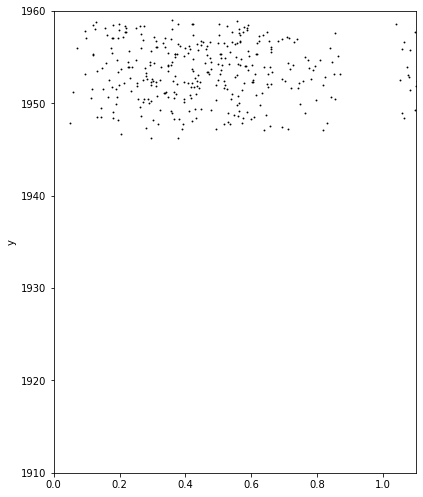

In [120]:

fig = plt.figure(figsize=(6.5, 8.5))
ax = plt.axes(xlim=(0.0, 1.1), ylim=(1910, 1960))


# for i in range(0,90,1):
    
#     xdia = 2*np*1*x

#     xtrans = np.sin((subset_testplot['x']*2-1)*np.pi  +  i*np.pi/180) 
scat = ax.scatter(subset_testplot['x'],subset_testplot['y'],marker='.',s=3,c='#000000')
# ax.set(xlim=(-1.1, 1.1), ylim=(1910, 1960))

    # plt.title('Simple scatter')
    # plt.xlabel('x')
plt.ylabel('y')
# fig.set_size_inches(6.5, 8.5)
plt.draw()
plt.show()
# i=1
# fig.savefig('testAnim'+str(i)+'.png', dpi=200, transparent=False)
# plt.cla()


In [102]:
pp.pprint(fullset[1])

{'abstr': 'Report presenting a flight investigation made of boundary-layer and '
         'profile-drag characteristics of smooth wing sections of a P-47D '
         'airplane. Measurements were made at three stations on the wing: '
         'boundary-layer measurements, pressure-distribution measurements, and '
         'wake surveys. The results indicated that a minimum profile-drag '
         'coefficient of 0.0062 for the smooth section at 63 percent semispan '
         'was obtained.',
'contributor': 'Langley Aeronautical Laboratory',
'creat2': ['Zalovcik, John A.'],
'creator': 'Zalovcik, John A.',
'date': '1945-10',
'doctype': ['NACA Advanced Confidential Reports', 'NACA Wartime Reports'],
'id_casi': '19780078667',
'id_hd': 'metadc53374',
'id_https': 'https://digital.library.unt.edu/ark:/67531/metadc53374/',
'id_repno': 'NASA-TM-79861',
'id_repno2': ['NASA-TM-79861', 'NACA-ACR-L5H11A'],
'id_url': 'http://hdl.handle.net/2060/19780078667',
'keywords': ['P-47D',
            'boundar

In [136]:
uniqueKeywords = []
uniqueSplitKeywords = []

for ind1,val1 in enumerate(fullset):
    for ind2, val2 in enumerate(val1['keywords']):
        if val2 not in uniqueKeywords:
            uniqueKeywords.append(str(val2))
            text = val2.split()
        for ind3, val3 in enumerate(text):
            if val3 not in uniqueSplitKeywords:
#                 if type(val3) is not None:
                uniqueSplitKeywords.append(str(val3))

            
print(len(uniqueKeywords))
print(len(uniqueSplitKeywords))

sortedlist = uniqueKeywords.sort()
print((uniqueKeywords))


sortedSplitlist = uniqueSplitKeywords.sort()
print((uniqueSplitKeywords))
      

7682
4647
['0-1HTA magnesium alloy', '0.1725c ailerons', '1,2,3-trimethylbenzene', '1-ethyl-3-methylbenzene', '1000 hp traffic airplane', '11-C', '110A weapons system', '14S-T aluminum alloy', '17S-T aluminum alloys', '19-9 DL alloy', '19-9DL alloy', '19B-8 engines', '19XB compressor', '19XB-1', '19XB-2A turbines', '2,2,4,4-tetramethylpentane', '2,3-dimethylpentane', '2-spar wings', '2024-T aluminum alloy', '2024-T3 aluminum', '2024-T3 aluminum alloy', '2024-T4 aluminum alloy', '24S aluminum alloy', '24S-T', '24S-T Alclad', '24S-T aluminum alloy', '24S-T aluminum alloys', '24S-T tension panels', '24S-T3 aluminum alloy', '4-engines', '61S-T aluminum alloy', '7075-T6 aluminum alloy', '75S-T aluminum alloy', '75S-T6 aluminum alloy', '7KS-6000 T-27 Jato', 'A-26', 'A-26B', 'A-5A', 'A.B. Flygindustri K 47', 'A.B.C Motors Robin', 'A.V.M. 132', 'AAF Project MX-800', 'AGARD Calibration Model B', 'AM-57S', 'AM-C52S', 'AMS 5385', 'AN-F-28 fuel', 'AN-F-58', 'AN-F-58 fuels', 'AN-M-65-AZON', 'AN/SPS